In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

In [3]:
sys.path.insert(0, '/ssd/scratch/khugueni/librascal-pypi-release/build')

In [4]:
%matplotlib inline
from matplotlib import pylab as plt

import time
import rascal

import ase
from ase import Atoms
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
from numpy.testing import assert_allclose
import numpy as np
from numpy.linalg import norm

from scipy.integrate import quad
from pylode.lib.radial_basis import innerprod
from scipy.special import gamma, hyp1f1, sph_harm, iv

# Descriptor related imports: compare the librascal and pyLODE versions of SOAP
from rascal.representations import SphericalExpansion as RascalSphericalExpansion
#from librascal.representations import SphericalExpansion as RascalSphericalExpansion
import rascaline
from pylode.lib.projection_coeffs import DensityProjectionCalculator

# Introduction

This notebook is used to compare the features obtained from rascaline, librascal and pylode. The goal is to fully understand the details of the three implementations to make sure that the same coefficients from different codes agree.

## Table of Contents:
* [Preparation](#preparation)
    * [Exact Expression for Coefficients](#exactexpressions)
    * [Get the features for dimers](#getfeatures)
* [Coefficients for $l=1$](#l=1)
    * [Explicit computation of coefficients for $l=1$](#l=1explicit)
    * [Comparison to pyLODE/rascal for dimers](#l=1dimer)
* [Coefficients for $l\geq 2$](#lgeq2)
    * [Coefficients for $l=2$](#l=2)
    * [Coefficients for general $l$](#l_general)
* [Coefficients for l=0](#l=0)
    * [Exact coefficients](#l=0exact)
    * [Comparison to pyLODE/rascal for center contribution](#l=0center)
    * [Comparison to pyLODE/rascal for dimers](#l=0dimer)

# Preparation: Get features from all three codes <a class="anchor" id="preparation"></a>

## Exact Expression for Coefficients <a class="anchor" id="exactexpressions"></a>

### Define common hyperparameters

In [5]:
nmax = 8
lmax = 3
rcut = 6.
smearing = 0.5

### Generate orthonormalization matrix <a class="anchor" id="orthonormalization"></a>

In [6]:
Nradial = 1000
sigma = np.ones(nmax, dtype=float)
for i in range(1, nmax):
    sigma[i] = np.sqrt(i)
sigma *= rcut / nmax

In [7]:
# Define inner product matrix using analytical expression for primitive GTOs
innerprods_primitive = np.zeros((nmax, nmax))
for n1 in range(nmax):
    for n2 in range(nmax):
        sigeff = 0.5 * (1/sigma[n1]**2 + 1/sigma[n2]**2)
        neff = 0.5 * (3 + n1 + n2)
        innerprods_primitive[n1, n2] = 0.5 * sigeff**(-neff) * gamma(neff)

eigvals, eigvecs = np.linalg.eigh(innerprods_primitive)
transformation_primitive = eigvecs @ np.diag(np.sqrt(1. / eigvals)) @ eigvecs.T

In [8]:
normalizations = np.zeros((nmax,))
for n in range(nmax):
    normalizations[n] = 1/np.sqrt(innerprods_primitive[n, n])

In [9]:
# Inner product matrix for normalized GTOs
innerprods_normalized = np.zeros((nmax, nmax))
for n1 in range(nmax):
    for n2 in range(nmax):
        innerprods_normalized[n1, n2] = innerprods_primitive[n1, n2]
        innerprods_normalized[n1, n2] *= normalizations[n1] * normalizations[n2]
        
eigvals, eigvecs = np.linalg.eigh(innerprods_normalized)
transformation_normalized = eigvecs @ np.diag(np.sqrt(1. / eigvals)) @ eigvecs.T

In [10]:
use_gto_convention = 'normalized' # choose between 'normalized' and 'primitive'
if use_gto_convention == 'normalized':
    transformation = transformation_normalized
    innerprods = innerprods_normalized
elif use_gto_convention == 'primitive':
    transformation = transformation_primitive
    innerprods = innerprods_primitive
    normalizations = np.ones_like(normalizations)

In [11]:
assert_allclose(transformation @ innerprods @ transformation, np.eye(nmax), atol=1e-5, rtol=1e-5)

### Fully analytical formula for general $l$

In [12]:
def coefficients_analytical_general_l(nmax, d, l):
    # Define auxilary quantities and prefactors
    a = 1. / (2 * smearing**2)
    lplus3half = l + 1.5
    prefac_global = np.pi**1.5 * sph_harm(0, l, 0, 0).real * a**l / gamma(lplus3half)
    prefac_global *= d**l * np.exp(-a*d**2)
    prefac_global /= (np.pi * smearing**2)**(3/4)

    # Start main loop
    featvec = np.zeros((nmax))
    for n in range(nmax):
        nlplus3half = (3 + n + l) / 2
        b = 1. / (2 * sigma[n]**2)
        prefac_n_dep = gamma(nlplus3half) / (a+b)**nlplus3half
        hyp = hyp1f1(nlplus3half, lplus3half, a**2*d**2/(a+b))
        featvec[n] = normalizations[n] * prefac_n_dep * hyp

    #return prefac_global * featvec
    return prefac_global * (transformation @ featvec)   

### Semianalytical (final integral performed numerically) formula for general l

In [13]:
def coefficients_semianalytical_general_l(nmax, d, l):
    # Prefactor
    a = 1. / (2 * smearing**2)
    prefac_global = 4*np.pi * sph_harm(0, l, 0, 0).real * np.exp(-a*d**2)
    prefac_global /= (np.pi * smearing**2)**(3/4)

    # Main loop performing the numerical integration
    featvec = np.zeros((nmax))
    for n in range(nmax):
        # Define the integrand consisting of a power-law, Gaussian and Bessel part
        b = 1. / (2 * sigma[n]**2)
        gaussian = lambda r: np.exp(-(a+b)*r**2)
        power = lambda r: r**(2+n)
        mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
        bessel = lambda r: mod_sph_bessel(2*a*d*r)
        integrand = lambda r: power(r) * gaussian(r) * bessel(r)
        
        # Numerical integration
        eps = 1e-10
        featvec[n] = normalizations[n] * quad(integrand, eps, 4.5*rcut)[0]

    #return prefac_global * featvec
    return prefac_global * (transformation @ featvec)   

## Get the features for dimers <a class="anchor" id="getfeatures"></a>

### Define structure to be used for the comparison
The main differences between librascal and the pyLODE implementation are the presence of a smooth cutoff function and the potentially different order in which neighbors are stored. We thus wish to generate structures for which these two effects do not alter the coefficients too much. For this task, we use clusters of Oxygen atoms for which all atoms have a mutual distance of less than 3A. Then, even for a relatively large smearing of 1.5A, the atomic densities will be reasonably contained within a ball of cutoff radius 6 that will also be used for the cutoff.

In [14]:
frames = []
cell = np.eye(3) * 16
Ndimers = 15
distances = np.linspace(1., 2.5, Ndimers)
for d in distances:
    positions = [[1,1,1],[1,1,1+d]]
    frame = Atoms('O2', positions=positions, cell=cell, pbc=True)
    frames.append(frame)

### Get the features from pyLODE

In [15]:
hypers = {
    'smearing':smearing,
    'max_angular':lmax,
    'max_radial':nmax,
    'cutoff_radius':rcut,
    'potential_exponent':0,
    'radial_basis': 'gto',
    'compute_gradients':False,
    'subtract_center_contribution':False,
    }

calculator_pylode = DensityProjectionCalculator(**hypers)
calculator_pylode.transform(frames)
features_pylode = calculator_pylode.features

### Get the features from librascal

In [16]:
# define the parameters of the spherical expansion
hypers = dict(interaction_cutoff=rcut, 
              max_radial=nmax, 
              max_angular=lmax, 
              gaussian_sigma_constant=smearing,
              gaussian_sigma_type="Constant",
              cutoff_smooth_width=0.1,
              radial_basis="GTO",
              compute_gradients=False,
              expansion_by_species_method='structure wise',
              optimization=dict(Spline=dict(accuracy=1e-12)),
              )

calculator_librascal = RascalSphericalExpansion(**hypers)
# compute the representation of all the structures
features_librascal = calculator_librascal.transform(frames).get_features(calculator_librascal)

### Get the features from Rascaline

In [17]:
HYPER_PARAMETERS = {
    "cutoff": rcut,
    "max_radial": nmax,
    "max_angular": lmax,
    "atomic_gaussian_width": smearing,
    "gradients": False,
    "center_atom_weight": 1.0,
    "radial_basis": {
        "Gto": {},
    },
    "cutoff_function": {
        "Step": {"width": 1e-3},
    },
}

calculator_rascaline = rascaline.SphericalExpansion(**HYPER_PARAMETERS)

# run the actual calculation
descriptor_rascaline = calculator_rascaline.compute(frames)

# Compare coefficients for $l=1$ <a class="anchor" id="l=1"></a>

## Explicit computation of coefficients for $l=1$ <a class="anchor" id="l=1explicit"></a>

To make sure that we understand every single aspect of the codes including all the prefactors and conventions, we compute the exact coefficients we would expect from an Oxygen molecule oriented along the z-axis. The computations are done using three (four) different methods: a fully analytical approach applicable to all $l$, a semi-analytical approach in which the final radial integral is evaluated numerically also valid for all $l$, and finally an explicit formula that was obtained directly for the special case $l=1$ starting at the very definition. For convenience, we also include the complete analytical formula for the special case $l=1$.

### Fully analytical formula for $l=1$

In [18]:
def coefficients_analytical_l1(nmax, d):
    # Define auxilary quantities and prefactors
    a = 1. / (2 * smearing**2)
    lplus3half = 2.5
    prefac_global = np.pi * np.sqrt(3/4) * a / gamma(lplus3half) * d * np.exp(-a*d**2)
    prefac_global /= (np.pi*smearing**2)**(3/4)
    
    # Start main loop
    featvec = np.zeros((nmax))
    for n in range(nmax):
        # Compute contribution for primitive GTO function
        nlplus3half = (4 + n) / 2
        b = 1. / (2 * sigma[n]**2)
        prefac_n_dep = gamma(nlplus3half) / (a+b)**nlplus3half
        hyp = hyp1f1(nlplus3half, lplus3half, a**2*d**2/(a+b))
        featvec[n] = normalizations[n] * prefac_n_dep * hyp

    return prefac_global * (transformation @ featvec)

### Semianalytical (final integral performed numerically) formula for $l=1$

In [19]:
def coefficients_semianalytical_l1(nmax, d):
    # Prefactor
    a = 1. / (2 * smearing**2)
    prefac = np.sqrt(1.5) / (2 * np.pi * smearing**3)
    prefac *= np.exp(-a*d**2)
    prefac *= (2*np.pi*smearing**2)**1.5 / (np.pi*smearing**2)**(3/4)
    
    # Start main loop
    featvec = np.zeros((nmax,))
    for n in range(nmax):
        # Start defining functions appearing in integrand
        b = 1. / (2 * sigma[n]**2)
        gaussian = lambda r: np.exp(-(a+b)*r**2)
        power = lambda r: r**(2+n)
        mod_sph_bessel = lambda x: (x*np.cosh(x) - np.sinh(x))/x**2
        bessel = lambda r: mod_sph_bessel(2*a*d*r)

        integrand = lambda r: power(r) * gaussian(r) * bessel(r) * 2
        
        # Numerical Integration
        featvec[n] = normalizations[n] * quad(integrand, 1e-10, 4.5 * rcut)[0]
    
    return prefac * (transformation @ featvec)

### Compare the coefficients obtained using different methods

In [20]:
features_analytical_l1 = np.zeros((len(distances), nmax))
features_semianalytical_l1 = np.zeros((len(distances), nmax))
features_analytical_general = np.zeros((len(distances), nmax))
features_semianalytical_general = np.zeros((len(distances), nmax))

for i_dist, d in enumerate(distances):
    features_analytical_l1[i_dist] = coefficients_analytical_l1(nmax, d)
    features_semianalytical_l1[i_dist] = coefficients_semianalytical_l1(nmax, d)
    features_analytical_general[i_dist] = coefficients_analytical_general_l(nmax, d, l=1)
    features_semianalytical_general[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=1)

In [21]:
delta1 = np.linalg.norm(features_analytical_l1 - features_analytical_general)
delta2 = np.linalg.norm(features_analytical_general - features_semianalytical_general)
delta3 = np.linalg.norm(features_semianalytical_l1 - features_semianalytical_general)
print(delta1)
print(delta2)
print(delta3)

1.6113655467566215e-16
3.2572434721308636e-14
6.728896395083236e-15


## Compare the exact values with those obtained from the three codes <a class="anchor" id="l=1dimer"></a>

The exact coefficients obtained using the analytical formula are now compared to those obtained from the three codes.

### Get the $l=1$ (and $m=0$) part of the features of the three codes

In [22]:
print('Shapes of feature vectors')
print('rascaline', descriptor_rascaline.values.shape)
print('librascal', features_librascal.shape)

Shapes of feature vectors
rascaline (30, 128)
librascal (30, 128)


In [23]:
features_L1_rascaline = descriptor_rascaline.values[0::2, 2*nmax:3*nmax] / 10.962374348347298 

In [24]:
features_L1_librascal = features_librascal[0::2, 2::(lmax+1)**2]

In [25]:
features_L1_pylode = features_pylode[0::2, 0, :, 2]

In [26]:
for i,features in enumerate([features_L1_rascaline, features_L1_librascal, features_L1_pylode, features_analytical_l1]):
    assert features.shape == (len(distances), nmax)

In [27]:
print(features_analytical_l1 / features_L1_pylode)

[[1.00002809 0.99998288 1.00002168 0.99984767 0.99480887 0.99592798
  1.02550283 1.00132204]
 [1.00005198 0.99998133 1.00000548 0.99993948 1.00012416 1.00011716
  1.00006189 0.99997893]
 [1.00003987 0.99999336 0.99999225 1.00011857 0.9998635  0.9998023
  0.99978185 0.99975851]
 [0.99999194 1.00001078 0.99998733 1.00020109 0.99982961 0.99976318
  0.99974776 0.99972082]
 [0.99993356 1.00002243 0.99999059 1.00012127 0.9998866  0.99983756
  0.99982353 0.99977325]
 [0.99990873 1.00001945 0.99999826 1.00001639 0.99998064 0.99997457
  0.99995735 0.99985746]
 [0.99995426 0.99999988 1.00000536 0.99996559 1.00006516 1.00014079
  1.00010329 0.99988659]
 [1.00006141 0.99997106 1.00000812 0.99996305 1.00009959 1.000344
  1.00019066 0.99956201]
 [1.00015783 0.99994949 1.00000552 0.9999822  1.00006167 0.99917506
  1.00105954 1.01766311]
 [1.0001511  0.99996026 0.99999943 1.00000221 0.9999686  1.00018909
  1.00059178 1.00179663]
 [1.00001741 1.00005341 0.99999362 1.00001284 0.9998872  1.00022492
  1.0

In [28]:
print(features_analytical_l1 / features_L1_rascaline)

[[73.1664572  73.1664572  73.1664572  73.16645719 73.16645718 73.16645717
  73.16645741 73.16645721]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645718 73.16645717]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645717 73.16645717]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645717 73.16645716]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645717 73.16645716]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645717 73.16645716]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645717 73.16645715]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645718
  73.16645715 73.16645714]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.16645719 73.16645724
  73.16645727 73.16645757]
 [73.1664572  73.1664572  73.1664572  73.1664572  73.1664572  73.16645719
  73.16645719 73.

In [29]:
print(features_semianalytical_general / features_L1_librascal)

[[26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730293]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.69730294]
 [26.69730293 26.69730293 26.69730293 26.69730293 26.69730293 26.69730293
  26.69730293 26.

In [30]:
for i, d in enumerate(distances):
    print('Distance ', i)
    coeffs_rascaline = descriptor_rascaline.values[2*i].reshape(((lmax+1)**2, nmax)).T
    coeffs_librascal = features_librascal[2*i].reshape((nmax,(lmax+1)**2))
    coeffs_pylode = features_pylode[2*i,0]
    
    for coeffs in [coeffs_rascaline, coeffs_librascal, coeffs_pylode]:
        print(coeffs[:,2] / features_analytical_general[i])
    
    print()

Distance  0
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.99997191 1.00001712 0.99997832 1.00015235 1.00521822 1.00408867
 0.97513139 0.99867971]

Distance  1
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.99994802 1.00001867 0.99999452 1.00006053 0.99987585 0.99988286
 0.99993811 1.00002107]

Distance  2
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.99996013 1.00000664 1.00000775 0.99988144 1.00013652 1.00019774
 1.0002182  1.00024155]

Distance  3
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.03745697 0.03745697 0.03745697 0.037

# Compare coefficients for $l\geq 2$ <a class="anchor" id="lgeq2"></a>

## Compare coefficients for $l=2$ <a class="anchor" id="l=2"></a>

In [31]:
lm_index = 6 # l**2 + l

In [32]:
print('Shapes of feature vectors')
print('rascaline', descriptor_rascaline.values.shape)
print('librascal', features_librascal.shape)

Shapes of feature vectors
rascaline (30, 128)
librascal (30, 128)


In [33]:
features_L2_rascaline = descriptor_rascaline.values[0::2, lm_index*nmax:(lm_index+1)*nmax]

In [34]:
features_L2_librascal = features_librascal[0::2, lm_index::(lmax+1)**2]

In [35]:
features_L2_pylode = features_pylode[0::2, 0, :, lm_index]

In [36]:
features_analytical_l2 = np.zeros((len(distances), nmax))
features_numerical_l2 = np.zeros((len(distances), nmax))

for i_dist, d in enumerate(distances):
    features_analytical_l2[i_dist] = coefficients_analytical_general_l(nmax, d, l=2)
    features_numerical_l2[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=2)

In [37]:
delta_l2 = np.linalg.norm(features_analytical_l2 - features_numerical_l2)

In [38]:
print(features_L2_pylode / features_analytical_l2)

[[1.00003765 1.00003907 0.99991463 1.00082442 0.99768113 0.99726798
  0.99784288 0.99843231]
 [0.99992621 1.00004647 0.99995205 1.00074974 0.99925219 0.99909866
  0.99917621 0.99930509]
 [0.99986331 1.00002646 0.99999458 1.00016865 0.99987659 0.99984856
  0.99986309 0.99987699]
 [0.99989788 0.9999889  1.00002284 0.99968885 1.00018865 1.00024909
  1.00025059 1.0002137 ]
 [1.00002754 0.9999528  1.0000303  0.99966114 1.00028168 1.00039828
  1.00039061 1.00031372]
 [1.00017933 0.99994002 1.00002024 0.99983158 1.00020758 1.0003247
  1.00028913 1.00015478]
 [1.00023195 0.9999668  1.00000179 0.99998182 1.00003085 1.00001446
  0.9998887  0.99963034]
 [1.00009778 1.00003544 0.99998549 1.00005397 0.99983804 0.99912315
  0.99855203 0.99789936]
 [0.99982619 1.0001277  0.99997921 1.00006136 0.99972917 1.00334856
  1.00422927 1.01021579]
 [0.99961594 1.00019833 0.99998539 1.0000352  0.99977664 1.00057033
  1.00100395 1.00216303]
 [0.99966834 1.00013179 1.00000029 1.00000353 0.99994403 1.0001487
  1.

In [39]:
print(features_L2_pylode / features_numerical_l2)

[[1.00003765 1.00003907 0.99991463 1.00082442 0.99768113 0.99726798
  0.99784288 0.99843231]
 [0.99992621 1.00004647 0.99995205 1.00074974 0.99925219 0.99909866
  0.99917621 0.99930509]
 [0.99986331 1.00002646 0.99999458 1.00016865 0.99987659 0.99984856
  0.99986309 0.99987699]
 [0.99989788 0.9999889  1.00002284 0.99968885 1.00018865 1.00024909
  1.00025059 1.0002137 ]
 [1.00002754 0.9999528  1.0000303  0.99966114 1.00028168 1.00039828
  1.00039061 1.00031372]
 [1.00017933 0.99994002 1.00002024 0.99983158 1.00020758 1.0003247
  1.00028913 1.00015478]
 [1.00023195 0.9999668  1.00000179 0.99998182 1.00003085 1.00001446
  0.9998887  0.99963034]
 [1.00009778 1.00003544 0.99998549 1.00005397 0.99983804 0.99912315
  0.99855203 0.99789936]
 [0.99982619 1.0001277  0.99997921 1.00006136 0.99972917 1.00334856
  1.00422927 1.01021579]
 [0.99961594 1.00019833 0.99998539 1.0000352  0.99977664 1.00057033
  1.00100395 1.00216303]
 [0.99966834 1.00013179 1.00000029 1.00000353 0.99994403 1.0001487
  1.

In [40]:
print(features_L2_librascal / features_numerical_l2)

[[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  0.03745697 0.03745697]
 [0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
  

In [41]:
print(features_L2_rascaline / features_numerical_l2)

[[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  0.14982787 0.14982787]
 [0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
  

## Compare coefficients for general $l$ <a class="anchor" id="l_general"></a>

In [42]:
for l in range(1, lmax+1):
    lm_index = l**2 + l
    
    # Get the features from the spherical expansion codes
    features_l_pylode = features_pylode[0::2, 0, :, lm_index]
    features_l_rascaline = descriptor_rascaline.values[0::2, lm_index*nmax:(lm_index+1)*nmax] 
    features_l_librascal = features_librascal[0::2, lm_index::(lmax+1)**2]
    
    # Get the features from the analytical and numerical evaluations
    features_l_analytical = np.zeros((len(distances), nmax))
    features_l_numerical = np.zeros((len(distances), nmax))
    for i_dist, d in enumerate(distances):
        features_l_analytical[i_dist] = coefficients_analytical_general_l(nmax, d, l=l)
        features_l_numerical[i_dist] = coefficients_semianalytical_general_l(nmax, d, l=l)
    assert_allclose(features_l_analytical, features_l_numerical, atol=1e-9, rtol=1e-7)
    
    # Compare the coefficients
    ratios = features_l_pylode / features_l_analytical
    err = np.linalg.norm(features_l_analytical - features_l_numerical)
    ratios_rascal = features_l_pylode / features_l_rascaline
    print(f'pyLODE vs analytical coefficients for l = {l}')
    print(np.round(ratios,6))
    print(f'pyLODE vs rascaline coefficients for l = {l}')
    print(np.round(ratios_rascal, 6))
    print('Difference between numerical and analytical evaluation = ', err)
    print()

pyLODE vs analytical coefficients for l = 1
[[0.999972 1.000017 0.999978 1.000152 1.005218 1.004089 0.975131 0.99868 ]
 [0.999948 1.000019 0.999995 1.000061 0.999876 0.999883 0.999938 1.000021]
 [0.99996  1.000007 1.000008 0.999881 1.000137 1.000198 1.000218 1.000242]
 [1.000008 0.999989 1.000013 0.999799 1.00017  1.000237 1.000252 1.000279]
 [1.000066 0.999978 1.000009 0.999879 1.000113 1.000162 1.000176 1.000227]
 [1.000091 0.999981 1.000002 0.999984 1.000019 1.000025 1.000043 1.000143]
 [1.000046 1.       0.999995 1.000034 0.999935 0.999859 0.999897 1.000113]
 [0.999939 1.000029 0.999992 1.000037 0.9999   0.999656 0.999809 1.000438]
 [0.999842 1.000051 0.999994 1.000018 0.999938 1.000826 0.998942 0.982643]
 [0.999849 1.00004  1.000001 0.999998 1.000031 0.999811 0.999409 0.998207]
 [0.999983 0.999947 1.000006 0.999987 1.000113 0.999775 0.999416 0.998494]
 [1.000158 0.998914 1.000008 0.999987 1.00012  0.999805 0.999407 0.998439]
 [1.000243 1.00024  1.000004 0.999994 1.000071 0.999848 

# Coefficients for $l=0$  <a class="anchor" id="l=0"></a>

## Compute the exact expressions for reference <a class="anchor" id="l=0exact"></a>

### Hybrid analytical-numerical computation

Here, we use the convention that the Gaussian density is normalized to one, i.e. contains the factor of $1/(2\pi\sigma^2)^{3/2}$. The spherical harmonic $Y_{00}$ is the constant function whose value is $1/\sqrt{4\pi}$ and the GTO's are orthonormalized starting from the primitive ones using the usual procedure.

In [43]:
def compute_coeffs_explicit_l0(d):
    # Start computing coefficients for l=0
    featvec = np.zeros((nmax))
    
    # Case 1: If the distance is zero, the integrals
    # can easily be computed by hand. Furthermore,
    # separating this case out is convenient since
    # the general expression as a function of the pair
    # distance d has a (removable) singularity at d=0
    if d == 0:
        prefac = np.sqrt(np.pi)
        prefac /= (np.pi*smearing**2)**(3/4)
        
        featvec = np.zeros((nmax))
        for n in range(nmax):
            b = 0.5 * (1/smearing**2 + 1/sigma[n]**2)
            neff = (3+n) / 2
            featvec[n] = prefac * normalizations[n] * b**(-neff) * gamma(neff)
    
    # Case 2: For nonzero pair distances (i.e. all proper neighbor contributions),
    # the final integral over the radial variable results in a hypergeometric function
    # in a fully analytical treatment. Here, we perform the final integral numerically.
    else:
        # Define auxilary quantities and prefactors
        a = d / smearing**2
        prefac = 1. / (np.sqrt(2) * np.pi * smearing * d) * np.exp(-0.5*d**2/smearing**2)
        prefac *= (2*np.pi*smearing**2)**1.5 / (np.pi*smearing**2)**(3/4)
        
        # Start main loop
        for n in range(nmax):
            # Compute contribution for primitive GTO function
            powerlaw = lambda r: r**(1+n)
            b = 0.5 * (1/smearing**2 + 1/sigma[n]**2)
            gaussian = lambda r: np.exp(-b * r**2)
            sinh = lambda r: np.sinh(a * r)
            integrand = lambda r: powerlaw(r) * gaussian(r) * sinh(r)

            # Numerical Integration
            featvec[n] = prefac * normalizations[n] * quad(integrand, 1e-10, 4.5 * rcut)[0]
    #return featvec
    return transformation @ featvec

Text(0, 0.5, 'Contribution to <n00|rho_i>')

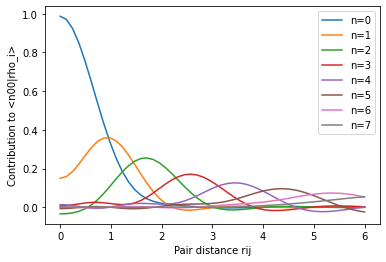

In [44]:
# Start plotting the behavior of the neighbor contribution as a function of the pair distance r_ij
Ndist = 50
dd = np.linspace(0, rcut, Ndist)
coeffs_exact = np.zeros((nmax, Ndist))
for i, d in enumerate(dd):
    coeffs_exact[:,i] = compute_coeffs_explicit_l0(d)


# Make plot
for n in range(nmax):
    plt.plot(dd, coeffs_exact[n], label=f'n={n}')
plt.legend()
plt.xlabel('Pair distance rij')
plt.ylabel('Contribution to <n00|rho_i>')

Remark: This plot was mostly used to make sure that the implementation for small distances $r_{ij} \rightarrow 0$ does indeed converge to the special case $r_{ij}=0$ which is implemented separately.

### Comparison to fully analytical general expression

In [45]:
coeffs_from_general_analytical = np.zeros((nmax, Ndist))
coeffs_from_general_numerical = np.zeros((nmax, Ndist))
for i, d in enumerate(dd):
    coeffs_from_general_analytical[:,i] = coefficients_analytical_general_l(nmax, d, l=0)
    coeffs_from_general_numerical[:,i] = coefficients_semianalytical_general_l(nmax, d, l=0)

<ipython-input-13-71a9a352488c>:14: RuntimeWarning: divide by zero encountered in double_scalars
  mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
<ipython-input-13-71a9a352488c>:14: RuntimeWarning: invalid value encountered in double_scalars
  mod_sph_bessel = lambda x: np.sqrt(np.pi/2/x) * iv(l + 0.5, x)
<ipython-input-13-71a9a352488c>:20: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  featvec[n] = normalizations[n] * quad(integrand, eps, 4.5*rcut)[0]


Text(0, 0.5, 'Contribution to <n00|rho_i>')

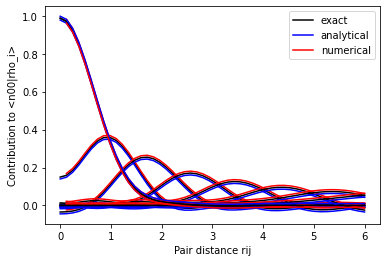

In [46]:
# Make plot
for n in range(nmax):
    plt.plot(dd, coeffs_exact[n], 'k')
    plt.plot(dd, -0.01+coeffs_from_general_analytical[n], 'b')
    plt.plot(dd, 0.01+coeffs_from_general_numerical[n], 'r')
    
plt.plot(dd, coeffs_exact[0], label=f'exact', c='k')
plt.plot(dd, 0.01+coeffs_from_general_analytical[0], label=f'analytical', c='b')
plt.plot(dd, -0.01+coeffs_from_general_numerical[0], label=f'numerical', c='r')
plt.legend()
plt.xlabel('Pair distance rij')
plt.ylabel('Contribution to <n00|rho_i>')

In [47]:
for n in range(nmax):
    diff1 = coeffs_exact[n] - coeffs_from_general_analytical[n]
    diff2 = coeffs_from_general_numerical[n] - coeffs_from_general_analytical[n]
    print(np.linalg.norm(diff1))
    print(np.linalg.norm(diff2[1:])) # first entry at d=0 is NaN for numerical evaluation

2.065819130578419e-15
1.87931397382568e-15
4.2105373992304264e-15
4.3846121415455044e-15
1.0083629377644011e-14
1.0187525901307643e-14
2.6263277329377824e-14
2.666590151462467e-14
4.6813404661281836e-14
4.6007622750133644e-14
5.368092002428532e-14
5.429256333417508e-14
3.63123144249675e-14
3.560648353002623e-14
1.2006001755488933e-14
1.1910038537128725e-14


## Compare exact coefficients with those from pyLODE and Rascal: Center atom contribution <a class="anchor" id="l=0center"></a>

Note that $l=0$ is more complicated compared to $l=1,2,\dots$ even for dimers since the center atom contributes to the density as well. We begin this investigation by using a frame that only consists of a single atom.

### Get the coefficients from the three codes

In [48]:
Nscalings = 4
scalings = np.linspace(1, 1.5, Nscalings)
for scale in scalings:
    frames.append(Atoms('O', positions=[[1,1,1]], cell=scale * cell, pbc=True))
#frames.append(Atoms('O', positions=[[1,1,1]], cell=cell, pbc=True))
#frames.append(Atoms('O', positions=[[1,1,1]], cell=1.2*cell, pbc=True))
#frames.append(Atoms('O', positions=[[1,1,1]], cell=1.4*cell, pbc=True))

In [49]:
calculator_pylode.transform(frames)
features_pylode_single = calculator_pylode.features[-Nscalings:]
features_librascal_single = calculator_librascal.transform(frames).get_features(calculator_librascal)[-Nscalings:]
features_rascaline_single = calculator_rascaline.compute(frames).values[-Nscalings:]

### Sanity check 1: Make sure the feature vectors only contain nonzero entries for l=0

In [50]:
features_pylode_single.shape

(4, 1, 8, 16)

In [51]:
features_librascal_single.shape

(4, 128)

In [52]:
features_rascaline_single.shape

(4, 128)

In [53]:
for i in range(Nscalings):
    print(np.round(features_pylode_single[i,0,:,:].T, 6))

[[ 9.87419e-01  1.49696e-01 -3.46860e-02  7.25100e-03  1.33660e-02
  -7.26300e-03  7.29000e-04  1.87000e-04]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00  0.00000e+00]
 [-0.00000e+00 -0.00000e+00 -0.00000e+00 -0.00000e+00  0.00000e+00
  -0.00000e+00 -0.00000e+00 -0.00000e+00]
 [ 0.00000e+00  0.00000e+00 -0.00000e+00 -0.00000e+00  0.00000e+00
  -0.00000e+00 -0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00 -0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.00000e+00  0.00000e+00 -0.00000e+00  0.00000e+00
   0.00000e+00  0.00000e+00 -0.00000e+00]
 [ 0.00000e+00 -0.00000e+00  0.00000e+00 -0.00000e+00  0.00000e+00
   0.00000e+00 -0.00000e+00  0.00000e+00]
 [ 0.00000e+00  0.0

In [54]:
print(features_rascaline_single)

[[ 1.47950245e-01  2.24165151e-02 -5.18950965e-03  1.07896275e-03
   2.00878241e-03 -1.09209148e-03  1.10944195e-04  2.76235594e-05
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

Comment: Rascaline seems to exclude the center contribution by default, leading to coefficients that are zero everywhere. This is not an error of the code per se, but is something that should be kept in mind.

Make sure that the coefficients apart from those at $l=0$ are zero (since we only have a single atom in the structure, the density is spherically symmetric and thus only the $l=0$ projection survives)

In [55]:
for i in range(len(features_pylode_single)):
    # The l=0 coefficients for pyLODE are contained in [n,l]=[:,0]
    feat = features_pylode_single[i,0]
    feat_zero = feat[:,1:]
    assert_allclose(feat_zero, np.zeros_like(feat_zero), atol=3e-6)
    
    # The l=0 coefficients for librascal are separated by (lmax+1)**2
    feat = features_librascal_single[i]
    for n in range(nmax):
        for lm in range((lmax+1)**2):
            if lm != 0:
                assert abs(feat[n*(lmax+1)**2 + lm]) < 1e-8
    
    # The l=0 coefficients of rascaline are the first nmax entries.
    # Thus, all the remaining contributions should be zero.
    feat = np.round(features_rascaline_single[i],15)
    #assert_allclose(feat[nmax:], np.zeros_like(feat[nmax:]), atol=1e-8)

### Sanity check 2: Coefficients should be (for pyLODE: mostly) independent of the cell

In [56]:
# For librascal and rascaline, the features should be completely independent of the cell
for feats in [features_librascal_single]:
    feat1 = feats[0]
    feat2 = feats[1]
    assert_allclose(feat1, feat2, rtol=1e-10)

In [57]:
# For pyLODE, the k-space sum does lead to a weak dependence on the cell that depends on
# how well the k-space converged.
feat1 = features_pylode_single[0]
feat2 = features_pylode_single[1]
assert_allclose(feat1, feat2, rtol=1e-10, atol=1e-5)

### Compare pyLODE and rascal coefficients with exact values

In [58]:
coeffs_exact_center = coeffs_exact[:,0] # take the r_{ij} = 0 part

In [59]:
print('Exact center contributions', coeffs_exact_center)

Exact center contributions [ 9.87468127e-01  1.49615124e-01 -3.46364778e-02  7.20134882e-03
  1.34072681e-02 -7.28897425e-03  7.40477692e-04  1.84368634e-04]


In [60]:
print('pyLODE / exact coeffs')
for i in range(Nscalings):
    feat_pylode_single_nonzero = features_pylode_single[i,0,:,0]
    print(feat_pylode_single_nonzero / coeffs_exact_center)

pyLODE / exact coeffs
[0.99995039 1.00054158 1.00142997 1.00684733 0.99690512 0.99642194
 0.98511848 1.01407865]
[0.99995013 1.00054407 1.0014365  1.00688311 0.99688481 0.99641142
 0.98537902 1.012638  ]
[0.99995022 1.00054319 1.0014343  1.00687346 0.99688953 0.99640547
 0.98504982 1.0131837 ]
[0.9999501  1.00054428 1.00143669 1.00687924 0.99689212 0.99642712
 0.98531401 1.01423748]


In [61]:
print('librascal / exact coeffs')
for i in range(Nscalings):
    feat_librascal_single_nonzero = features_librascal_single[i,::(lmax+1)**2]
    print(feat_librascal_single_nonzero / coeffs_exact_center)

librascal / exact coeffs
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]
[0.03745697 0.03745697 0.03745697 0.03745697 0.03745697 0.03745697
 0.03745697 0.03745697]


In [62]:
print('rascaline / exact coeffs')
for i in range(Nscalings):
    feat_rascaline_single_nonzero = features_rascaline_single[i,:nmax]
    print(feat_rascaline_single_nonzero / coeffs_exact_center)

rascaline / exact coeffs
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]
[0.14982787 0.14982787 0.14982787 0.14982787 0.14982787 0.14982787
 0.14982787 0.14982787]


## Norm tests

In [63]:
features_pylode_single = calculator_pylode.features[-Nscalings:]
features_pylode_dimers = calculator_pylode.features[:-Nscalings]

In [64]:
norm_exact_single = 1.
norm_exact_dimers = np.zeros((Ndimers,))

for i, d in enumerate(distances):
    norm_exact_dimers[i] = norm_exact_single * np.sqrt(2 + np.exp(-d**2/(4 * smearing**2)))

In [65]:
features_pylode_dimers.shape

(30, 1, 8, 16)

In [66]:
for features in features_pylode_single:
    print(norm(features.flatten()))
    print(norm_exact_single)

0.9994464149884253
1.0
0.999446226522141
1.0
0.9994462915624431
1.0
0.9994462095327907
1.0


In [67]:
norm_pylode_single = np.zeros((2,))
for i in range(2):
    norm_pylode_single[i] = norm(features_pylode_single[i].flatten())

In [68]:
print(norm_pylode_single)
print(norm_exact_single)

[0.99944641 0.99944623]
1.0


In [69]:
norm_pylode_dimers = np.zeros_like(distances)
for i,d in enumerate(distances):
    norm_pylode_dimers[i] = norm(features_pylode_dimers[i].flatten())

(0.0, 1.6582532588143946)

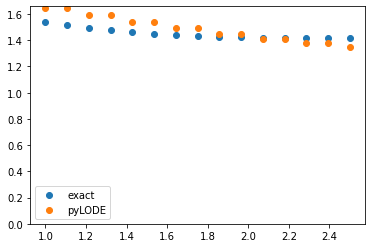

In [70]:
plt.scatter(distances, norm_exact_dimers, label='exact')
plt.scatter(distances, norm_pylode_dimers, label='pyLODE')
plt.legend()
plt.ylim(0,)

# Compare coefficients for random molecules <a class="anchor" id="randommolecule"></a>

In [71]:
frames = []
frames.append(Atoms('O4', positions=[[1,1,1],[2,1,1],[2,2.2,1],[2.3,2.,1.5]], cell=cell, pbc=True))
frames.append(Atoms('O4', positions=[[1,1,1],[2.3,1,1],[2.2,2.5,1.1],[2.7,2.,1.1]], cell=cell, pbc=True))

In [72]:
features_librascal_single = calculator_librascal.transform(frames).get_features(calculator_librascal)
calculator_pylode.transform(frames)
features_pylode_single = calculator_pylode.features

In [73]:
features_librascal_single.shape

(8, 128)

In [74]:
features_pylode_single = features_pylode_single[:,0,:,:]

In [75]:
f_librascal = features_librascal_single.reshape((8, nmax, (lmax+1)**2))

In [76]:
for i in range(8):
    print(np.round(features_pylode_single[i] / f_librascal[i], 6))
    ratiomax = np.max(features_pylode_single[i] / f_librascal[i])
    ratiomin = np.min(features_pylode_single[i] / f_librascal[i])
    print(ratiomax)
    print(ratiomin)

[[26.69627  26.698631 26.696885 26.696993 26.702275 26.702361 26.699788
  26.701954 26.698153 26.70552  26.711341 26.700961 26.712631 26.706385
  26.71364  26.72743 ]
 [26.700296 26.697203 26.697746 26.697575 26.69647  26.69733  26.697399
  26.697445 26.69859  26.694919 26.694429 26.695302 26.694188 26.6961
  26.694006 26.714839]
 [26.694757 26.697204 26.697111 26.697077 26.697391 26.697079 26.696958
  26.697058 26.695018 26.697537 26.697492 26.697575 26.697507 26.697414
  26.697518 26.697839]
 [26.710788 26.697971 26.698306 26.698754 26.696617 26.698107 26.699076
  26.698207 26.711773 26.696411 26.696471 26.69633  26.696396 26.695625
  26.696343 26.69713 ]
 [26.673758 26.695953 26.694711 26.693506 26.698662 26.695356 26.693958
  26.695107 26.642542 26.69884  26.699407 26.698559 26.699598 26.700646
  26.69974  26.69546 ]
 [26.655354 26.693804 26.68856  26.687727 26.700053 26.690236 26.689446
  26.689461 26.58177  26.69976  26.703925 26.699323 26.704426 26.703855
  26.704881 26.687233]


In [77]:
np.max(np.abs(features_pylode_single[i] / f_librascal[i])/2.82841)

9.52400202833425

In [78]:
features_pylode_single.shape

(8, 8, 16)

Comment: Coefficients now also agree for "generic" molecules (i.e. molecules that do not have any special symmetry) up to a global factor!

## Table of Contents:
* [Preparation](#preparation)
    * [Exact Expression for Coefficients](#exactexpressions)
    * [Get the features for dimers](#getfeatures)
* [Coefficients for $l=1$](#l=1)
    * [Explicit computation of coefficients for $l=1$](#l=1explicit)
    * [Comparison to pyLODE/rascal for dimers](#l=1dimer)
* [Coefficients for $l\geq 2$](#lgeq2)
    * [Coefficients for $l=2$](#l=2)
    * [Coefficients for general $l$](#l_general)
* [Coefficients for l=0](#l=0)
    * [Exact coefficients](#l=0exact)
    * [Comparison to pyLODE/rascal for center contribution](#l=0center)
    * [Comparison to pyLODE/rascal for dimers](#l=0dimer)